<a href="https://colab.research.google.com/github/MasterBeard/EigenCluster-Tokenization-for-Financial-Transformers/blob/main/Implementation_EigenCluster_Tokenization_for_Financial_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EigenCluster Tokenization Implementation for Financial Time Series

This code repository provides the implementation of **EigenCluster Tokenization** methodology as presented in the paper:  

**"EigenCluster Tokenization for Financial Transformers: Bullish Signal Prediction"**  

## Key Features

1. **Core Implementation**:
   - Complete pipeline for financial time series tokenization
   - EigenCluster algorithm with multi-scale feature reduction
   - Dynamic clustering with PCA-transformed features (Eigenvectors scalars)

2. **Reproduction Study**:
   - Full replication of the 2015-2024 CSI300 constituent stocks prediction
   - Includes data preprocessing, feature engineering, and model training components

3. **Technical Notes**:
   - Code comments were primarily generated with DeepSeek's assistance
   - Please refer to the original paper for authoritative terminology and methodological details
   - Discrepancies between code comments and the paper should defer to the original publication

4. **Dependencies**:
   ```python
   numpy, sklearn, torch, imblearn

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

# Define index codes
tickers = {
    'SSEC': '000001.SS', # Shanghai Composite
    'SZSC': '399001.SZ', # Shenzhen Component
}

idm = -2
date_ranges = {
    'train': ("2004-01-01", "2013-12-31"),
    'val': ("2014-01-02", "2014-12-31")
}

# Initialize data storage
data_splits = {split: {'features': [], 'norm_features': [], 'labels': []} for split in date_ranges}

# Window length
window_size = 11

# Process train and val data
for split in ['train', 'val']:
    start_date, end_date = date_ranges[split]
    index_data = {}
    for name, ticker in tickers.items():
        if ticker.endswith('.SZ') or ticker.endswith('.SS'):
            index_data[name] = yf.Ticker(ticker).history(start=start_date, end=end_date, auto_adjust=True)
        else:
            index_data[name] = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)

    # Create feature vectors and labels
    for index_name, data in index_data.items():
        if data.empty:
            continue

        # Fix multi-level column names if needed
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = data.columns.get_level_values(0)

        open_values = data['Open'].dropna().values
        close_values = data['Close'].dropna().values
        low_values = data['Low'].dropna().values
        high_values = data['High'].dropna().values

        for start in range(len(data) - window_size + 1):
            open_row = open_values[start:start + window_size]
            low_row = low_values[start:start + window_size]
            high_row = high_values[start:start + window_size]
            close_row = close_values[start:start + window_size]

            # Build feature vector (unnormalized)
            combined = np.array([
                val for i in range(window_size)
                for val in (open_row[i], low_row[i], high_row[i], close_row[i])
            ])

            # Normalized feature vector
            norm_combined = np.array([
                (open_row[i] / close_row[idm],
                low_row[i] / close_row[idm],
                high_row[i] / close_row[idm],
                close_row[i] / close_row[idm])
                for i in range(window_size)
            ]).flatten()

            label = 1 if close_row[-1] > close_row[idm] else 0

            data_splits[split]['features'].append(combined)
            data_splits[split]['norm_features'].append(norm_combined)
            data_splits[split]['labels'].append(label)

# Convert to NumPy arrays
train_features = np.array(data_splits['train']['features'])
train_norm_features = np.array(data_splits['train']['norm_features'])
train_labels = np.array(data_splits['train']['labels'])

val_features = np.array(data_splits['val']['features'])
val_norm_features = np.array(data_splits['val']['norm_features'])
val_labels = np.array(data_splits['val']['labels'])

# Print shapes
print(f"Train features shape: {train_features.shape}")
print(f"Train norm_features shape: {train_norm_features.shape}")
print(f"Train labels shape: {train_labels.shape}")

print(f"Validation features shape: {val_features.shape}")
print(f"Validation norm_features shape: {val_norm_features.shape}")
print(f"Validation labels shape: {val_labels.shape}")

Train features shape: (4827, 44)
Train norm_features shape: (4827, 44)
Train labels shape: (4827,)
Validation features shape: (467, 44)
Validation norm_features shape: (467, 44)
Validation labels shape: (467,)


In [2]:
import pandas as pd
from google.colab import drive

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# Read the data file
file_path = "/content/drive/MyDrive/stock_data_qfq_2015_2024.csv"
df = pd.read_csv(file_path)

# Display the first 5 rows
print("Raw data:")
print(df.head())

Mounted at /content/drive
Raw data:
     ts_code  trade_date     open     high      low    close  pre_close  \
0  600519.SH    20241231  1525.40  1545.00  1522.01  1524.00    1525.00   
1  600519.SH    20241230  1533.97  1543.96  1525.00  1525.00    1528.97   
2  600519.SH    20241227  1528.90  1536.00  1519.50  1528.97    1527.79   
3  600519.SH    20241226  1534.00  1538.78  1523.00  1527.79    1530.00   
4  600519.SH    20241225  1538.80  1538.80  1526.10  1530.00    1538.82   

   change  pct_chg       vol       amount  
0   -1.00    -0.07  39354.45  6033540.366  
1   -3.97    -0.26  25129.82  3849542.646  
2    1.18     0.08  20759.32  3170191.445  
3   -2.21    -0.14  18286.51  2798840.003  
4   -8.82    -0.57  17123.39  2621061.878  


In [3]:
# Main processing pipeline
window_size = 11
test_features1 = []
test_norm_features1 = []
test_labels1 = []
successful_stocks = 0  # Counter for successfully processed stocks

for csv_file in np.unique(df['ts_code']):  # Process all stocks
    try:
        # Read and process data with special formatting
        ohlc = df[df['ts_code']==csv_file][::-1][['open', 'high', 'low', 'close']].reset_index(drop=True)

        if len(ohlc['open'].values) != 0:
            successful_stocks += 1

        # Check if data is empty
        if len(ohlc) == 0:
            print(f"{csv_file} has no data in 2015-2024 period")
            continue

        # Extract OHLC data
        open_vals = ohlc['open'].values
        high_vals = ohlc['high'].values
        low_vals = ohlc['low'].values
        close_vals = ohlc['close'].values

        # Build windowed data
        for start in range(len(ohlc) - window_size):
            window_open = open_vals[start:start+window_size]
            window_high = high_vals[start:start+window_size]
            window_low = low_vals[start:start+window_size]
            window_close = close_vals[start:start+window_size]

            # Build feature vector (Open, Low, High, Close order)
            feature_vec = np.array([
                val for i in range(window_size)
                for val in (window_open[i], window_low[i], window_high[i], window_close[i])
            ])

            # Calculate label (1 if price increased, 0 otherwise)
            label = 1 if window_close[-1] > window_close[-2] else 0

            test_features1.append(feature_vec)
            test_norm_features1.append(feature_vec/window_close[-2])  # Normalized features
            test_labels1.append(label)

    except Exception as e:
        print(f"Error processing {csv_file}: {str(e)}")
        continue

# Convert to NumPy arrays
if test_features1:  # Check if any data was generated
    test_features1 = np.array(test_features1)
    test_norm_features1 = np.array(test_norm_features1)  # Shape changes from (N,44) to (N,44,1)
    test_labels1 = np.array(test_labels1)
else:
    test_features1 = np.array([])
    test_labels1 = np.array([])
    test_norm_features1 = np.array([])

# Output results
print("\nTest set generation results:")
if len(test_features1) > 0:
    print(f"Feature matrix shape: {test_features1.shape}")
    print(f"Normalized feature matrix shape: {test_norm_features1.shape}")
    print(f"Number of successfully processed stocks: {successful_stocks}")
    print(f"Label distribution - Up: {np.mean(test_labels1):.1%}, Down: {1-np.mean(test_labels1):.1%}")
else:
    print("No features generated - please check input file or date range")


Test set generation results:
Feature matrix shape: (633768, 44)
Normalized feature matrix shape: (633768, 44)
Number of successfully processed stocks: 300
Label distribution - Up: 47.5%, Down: 52.5%


In [4]:
import numpy as np
from sklearn.cluster import KMeans

# ============================================
# Utility Functions
# ============================================
def extract_normalized_daily_ohlc(matrices, epsilon=1e-6):
    """
    Extracts 5-day windows (each 5×4 = 20 dimensions) from each 44-dim vector,
    producing 7 windows per vector. Each window is normalized by its 4th day's close price.

    Args:
        matrices: Input array of OHLC vectors (each 44 dimensions)
        epsilon: Small value to avoid division by zero

    Returns:
        Array of normalized windows with shape [N_samples × 7, 20]
    """
    all_windows = []

    for vec in matrices:
        reshaped = vec.reshape(-1, 4)  # Reshape to (11 days, 4 features)
        for i in range(1, reshaped.shape[0] - 10 + 1):  # 7 sliding windows
            window = reshaped[i:i + 10]  # Extract 5-day window (5, 4)
            flat = window.flatten()      # Flatten to (20,)

            # Normalize by the 4th day's close price (flat[15])
            denominator = flat[-5]
            if abs(denominator) < epsilon:
                denominator = 1.0  # Prevent division by zero

            normalized = flat / denominator
            all_windows.append(normalized)

    return np.array(all_windows)  # shape: [N_samples × 7, 20]

# Extract normalized windows for each dataset
train_days = extract_normalized_daily_ohlc(train_features)
val_days = extract_normalized_daily_ohlc(val_features)

In [5]:
from sklearn.decomposition import PCA, NMF, TruncatedSVD

# 1. Principal Component Analysis (PCA) - Variance Maximization
# Initialize PCA with all components (same dimension as input)
pca = PCA(n_components=train_days.shape[1])

# Fit PCA on training data and transform both train/val sets
# Note: Typically we would fit only on training data and transform validation,
# but current implementation fits separately (may want to change this)
train_1d = pca.fit_transform(train_days)  # Transform training data
val_1d = pca.fit_transform(val_days)     # Transform validation data

# Create clustering features by combining:
# 1) Mean of sine-transformed components (captures periodic patterns)
# 2) Vector magnitude (Euclidean norm)
# This creates a 1D feature space for clustering
train_theta = (np.mean(np.sin(train_1d), axis=1) * np.linalg.norm(train_1d, axis=1)).reshape(-1, 1)
val_theta = (np.mean(np.sin(val_1d), axis=1) * np.linalg.norm(val_1d, axis=1)).reshape(-1, 1)

In [6]:
from sklearn.decomposition import PCA
import numpy as np
from sklearn.cluster import KMeans

# Define feature reduction steps [40, 36, 32, ..., 4]
feature_steps = list(range(40, 3, -4))  # 10 steps total

# Store PCA and clustering models for each step
pca_models = []
cluster_models = []

# === 1. Fit PCA and Clustering Models on Training Data ===
for n_features in feature_steps:
    # Select subset of features
    X_train = train_days[:, :n_features]

    # Create and store PCA model (using all components)
    pca = PCA(n_components=X_train.shape[1])
    pca_1d = pca.fit_transform(X_train)
    pca_models.append(pca)

    # Create theta feature combining:
    # - Mean of sine-transformed components (periodic patterns)
    # - Vector magnitude (Euclidean norm)
    pca_theta = (np.mean(np.sin(pca_1d), axis=1) * np.linalg.norm(pca_1d, axis=1)).reshape(-1, 1)

    # Determine number of clusters (9 for first matrix, 10 for others)
    n_clusters = 9 if n_features == 40 else 10

    # Train and store KMeans model
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(pca_theta)
    cluster_models.append(kmeans)

# === 2. Transform All Datasets ===
def generate_clusters(data, pca_models, cluster_models, feature_steps):
    """
    Convert data into cluster label matrix (n_samples, 10)

    Args:
        data: Input data matrix
        pca_models: List of trained PCA models
        cluster_models: List of trained KMeans models
        feature_steps: List of feature dimensions used

    Returns:
        Matrix of cluster labels with shape (n_samples, n_steps)
    """
    clusters = np.zeros((data.shape[0], len(cluster_models)), dtype=int)

    # Precompute cluster label offsets to ensure unique labels across steps
    offsets = [0] * len(feature_steps)
    for i in range(1, len(feature_steps)):
        # Offset determined by number of clusters in previous step
        prev_n_clusters = 9 if feature_steps[i-1] == 40 else 10
        offsets[i] = offsets[i-1] + prev_n_clusters

    # Generate cluster labels for each feature reduction step
    for i, (pca, model) in enumerate(zip(pca_models, cluster_models)):
        # Use corresponding number of features
        X = data[:, :feature_steps[i]]

        # Transform using pre-trained PCA model
        pca_1d = pca.transform(X)
        pca_theta = (np.mean(np.sin(pca_1d), axis=1) * np.linalg.norm(pca_1d, axis=1)).reshape(-1, 1)

        # Apply offset to ensure unique cluster labels across steps
        if i == 0:
            clusters[:, i] = model.predict(pca_theta)
        else:
            clusters[:, i] = model.predict(pca_theta) + offsets[i]

    return clusters

# Generate cluster representations for all datasets
train_clusters = generate_clusters(train_days, pca_models, cluster_models, feature_steps)
val_clusters = generate_clusters(val_days, pca_models, cluster_models, feature_steps)

# Verify output shapes
print("Train clusters shape:", train_clusters.shape)
print("Validation clusters shape:", val_clusters.shape)

Train clusters shape: (4827, 10)
Validation clusters shape: (467, 10)


In [7]:
train_x = train_clusters[:,::-1]
val_x =  val_clusters[:,::-1]

y_train = train_x[:,-1]
y_val = val_x[:,-1]

In [8]:
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# 1. Analyze original class distribution (keep exactly as is)
train_counts = Counter(y_train)
print("Original training set class distribution:", train_counts)

# 2. Set target sample count - using median (keep exactly as is)
target_counts = int(np.median(list(train_counts.values())))
print("Target samples per class:", target_counts)

# 3. Define sampling strategies (modified: split oversampling approach)
# Use SMOTE for normal minority classes
smote_strategy = {k: target_counts for k in train_counts
                 if 2 <= train_counts[k] < target_counts}  # Need at least 2 samples for SMOTE
# Use random duplication for extreme minority classes
random_strategy = {k: target_counts for k in train_counts
                  if 0 < train_counts[k] < 2}  # Handle classes with only 1 sample
# Under sampling strategy for majority classes
under_strategy = {k: target_counts for k in train_counts
                 if train_counts[k] > target_counts}  # Keep as is

# 4. Create sampling pipeline (modified: multi-stage processing)
sampling_pipeline = Pipeline([
    # Stage 1: Handle extreme minority classes (classes with only 1 sample)
    ('random_over', RandomOverSampler(
        sampling_strategy=random_strategy,
        random_state=42
    )),
    # Stage 2: Normal SMOTE oversampling
    ('smote', SMOTE(
        sampling_strategy=smote_strategy,
        k_neighbors=2,  # Ensured each class has ≥2 samples
        random_state=42
    )),
    # Stage 3: Under sampling for majority classes
    ('under', RandomUnderSampler(
        sampling_strategy=under_strategy,
        random_state=42
    ))
])

# 5. Execute resampling (keep exactly as is)
try:
    train_x_resampled, y_train_resampled = sampling_pipeline.fit_resample(train_x, y_train)

    # 6. Check results (keep exactly as is)
    resampled_counts = Counter(y_train_resampled)
    print("Resampled training set class distribution:", resampled_counts)

except ValueError as e:
    print(f"Resampling failed: {e}")
    print("Recommendation: Check if any classes still have insufficient samples after preprocessing")

Original training set class distribution: Counter({np.int64(6): 2257, np.int64(0): 956, np.int64(1): 706, np.int64(8): 385, np.int64(7): 192, np.int64(4): 166, np.int64(5): 83, np.int64(3): 58, np.int64(2): 24})
Target samples per class: 192
Resampled training set class distribution: Counter({np.int64(0): 192, np.int64(1): 192, np.int64(2): 192, np.int64(3): 192, np.int64(4): 192, np.int64(5): 192, np.int64(6): 192, np.int64(7): 192, np.int64(8): 192})


In [9]:
import torch
import numpy as np

# Cluster assignment matrices from previous processing steps
# Shape: [n_samples, 10] where each row contains 10 consecutive cluster assignments
X_train = train_x_resampled  # Training set cluster assignments
X_val = val_x                # Validation set cluster assignments

# Flatten matrices into 1D sequences of cluster IDs
# This converts the 2D structure into continuous sequences suitable for embedding
train_flattened = X_train.ravel()  # Result shape: [n_samples * 10]
val_flattened = X_val.ravel()      # Result shape: [n_samples * 10]

# Convert to PyTorch tensors for embedding layer input
# Using LongTensor since these represent categorical cluster IDs (discrete values)
train_data = torch.LongTensor(train_flattened)
val_data = torch.LongTensor(val_flattened)

# Verification and debugging output
print(f"Training data tensor shape: {train_data.shape}")  # Expected: [total_windows]
print(f"Validation data tensor shape: {val_data.shape}")  # Expected: [total_windows]

Training data tensor shape: torch.Size([17280])
Validation data tensor shape: torch.Size([4670])


In [10]:
# Hyperparameters
batch_size = 4  # How many batches per training step
context_length = 9  # Length of the token chunk each batch
d_model = 64  # The size of our model token embeddings
num_blocks = 8  # Number of transformer blocks
num_heads = 4  # Number of heads in Multi-head attention
learning_rate = 1e-3  # 0.001
dropout = 0.1  # Dropout rate
max_iters = 2000  # Total of training iterations <- Change this to smaller number for testing
eval_interval = 50  # How often to evaluate
eval_iters = 20
max_token_value = train_clusters.max() + 1  # Number of iterations to average for evaluation
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Use GPU if it's available.
TORCH_SEED = 1337
torch.manual_seed(TORCH_SEED)

In [11]:
import os
import requests
import math
import torch.nn as nn
from torch.nn import functional as F
# Define Feed Forward Network
class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.d_model = d_model
        self.dropout = dropout
        self.ffn = nn.Sequential(
            nn.Linear(in_features=self.d_model, out_features=self.d_model * 4),
            nn.ReLU(),
            nn.Linear(in_features=self.d_model * 4, out_features=self.d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.ffn(x)

# Define Scaled Dot Product Attention
class Attention(nn.Module):
    def __init__(self, head_size: int):
        super().__init__()
        self.d_model = d_model
        self.head_size = head_size
        self.context_length = context_length
        self.dropout = dropout

        self.key_layer = nn.Linear(in_features=self.d_model, out_features=self.head_size, bias=False)
        self.query_layer = nn.Linear(in_features=self.d_model, out_features=self.head_size, bias=False)
        self.value_layer = nn.Linear(in_features=self.d_model, out_features=self.head_size, bias=False)
        self.register_buffer('tril', torch.tril(
            torch.ones((self.context_length, self.context_length))))  # Lower triangular mask
        self.dropout_layer = nn.Dropout(self.dropout)

    def forward(self, x):
        B, T, C = x.shape  # Batch size, Time steps(current context_length), Channels(dimensions)
        assert T <= self.context_length
        assert C == self.d_model
        q = self.query_layer(x)
        k = self.key_layer(x)
        v = self.value_layer(x)

        # Scaled dot product attention: Q @ K^T / sqrt(d_k)
        weights = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        # Apply masked attention
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        weights = F.softmax(input=weights, dim=-1)
        weights = self.dropout_layer(weights)

        # Apply dot product attention: weights @ V
        out = weights @ v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, head_size: int):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = head_size
        self.d_model = d_model
        self.context_length = context_length
        self.dropout = dropout

        self.heads = nn.ModuleList([Attention(head_size=self.head_size) for _ in range(self.num_heads)])
        self.projection_layer = nn.Linear(in_features=self.d_model, out_features=self.d_model)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.projection_layer(out)
        out = self.dropout_layer(out)
        return out

class TransformerBlock(nn.Module):

    def __init__(self, num_heads: int):
        super().__init__()
        self.d_model = d_model
        self.context_length = context_length
        self.head_size = d_model // num_heads  # head size should be divisible by d_model
        self.num_heads = num_heads
        self.dropout = dropout

        self.multi_head_attention_layer = MultiHeadAttention(head_size=self.head_size)
        self.feed_forward_layer = FeedForward()
        self.layer_norm_1 = nn.LayerNorm(normalized_shape=self.d_model)
        self.layer_norm_2 = nn.LayerNorm(normalized_shape=self.d_model)

    def forward(self, x):
        # Note: The order of the operations is different from the original Transformer paper
        # The order here is: LayerNorm -> Multi-head attention -> LayerNorm -> Feed forward
        x = x + self.multi_head_attention_layer(self.layer_norm_1(x))  # Residual connection
        x = x + self.feed_forward_layer(self.layer_norm_2(x))  # Residual connection
        return x

class TransformerLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.d_model = d_model
        self.context_length = context_length
        self.num_heads = num_heads
        self.num_blocks = num_blocks
        self.dropout = dropout
        self.max_token_value = max_token_value
        # Set up token embedding look-up table
        self.token_embedding_lookup_table = nn.Embedding(num_embeddings=self.max_token_value, embedding_dim=self.d_model)

        # Run all the transformer blocks
        # Different from original paper, here we add a final layer norm after all the blocks
        self.transformer_blocks = nn.Sequential(*(
                [TransformerBlock(num_heads=self.num_heads) for _ in range(self.num_blocks)] +
                [nn.LayerNorm(self.d_model)]
        ))
        self.language_model_out_linear_layer = nn.Linear(in_features=self.d_model, out_features=self.max_token_value)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        """
        # Set up position embedding look-up table
        # following the same approach as the original Transformer paper (Sine and Cosine functions)
        """
        position_encoding_lookup_table = torch.zeros(self.context_length, self.d_model)
        position = torch.arange(0, self.context_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.d_model, 2).float() * (-math.log(10000.0) / self.d_model))
        position_encoding_lookup_table[:, 0::2] = torch.sin(position * div_term)
        position_encoding_lookup_table[:, 1::2] = torch.cos(position * div_term)
        # change position_encoding_lookup_table from (context_length, d_model) to (T, d_model)
        position_embedding = position_encoding_lookup_table[:T, :].to(device)
        x = self.token_embedding_lookup_table(idx) + position_embedding
        x = self.transformer_blocks(x)
        # The "logits" are the output values of our model before applying softmax
        logits = self.language_model_out_linear_layer(x)

        if targets is not None:
            B, T, C = logits.shape
            logits_reshaped = logits.view(B * T, C)
            targets_reshaped = targets.view(B * T)
            loss = F.cross_entropy(input=logits_reshaped, target=targets_reshaped)
        else:
            loss = None
        return logits, loss

    def generate(self, idx, max_new_tokens):

        for _ in range(max_new_tokens):
            # Crop idx to the max size of positional embeddings table
            idx_crop = idx[:, -self.context_length:]

            # Get predictions
            logits, _ = self(idx_crop)  # logits: (B, T, C)

            # Get the last time step logits
            logits_last_timestep = logits[:, -1, :]  # Shape: (B, C)

            # Apply softmax to get probabilities
            probs = F.softmax(input=logits_last_timestep, dim=-1)

            # Select the most probable index for each sample in the batch
            idx_next = torch.argmax(probs, dim=-1, keepdim=True)  # Shape: (B, 1)

            # Append the sampled indices to idx
            idx = torch.cat((idx, idx_next), dim=1)  # Shape: (B, T+1)

        return idx

In [12]:
# Initialize the model
model = TransformerLanguageModel()
model = model.to(device)

# Get input embedding batch
def get_batch(split: str):
    data = train_data if split == 'train' else val_data
    idxs = torch.randint(low=0, high=np.rint((len(data)/(context_length+1))- 1).astype(np.int64), size=(batch_size,))*(context_length+1)
    x = torch.stack([data[idx:idx + context_length ] for idx in idxs]).to(device)
    y = torch.stack([data[idx +1:idx + context_length+1] for idx in idxs]).to(device)
    return x, y

# Calculate loss
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'valid']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x_batch, y_batch = get_batch(split)
            logits, loss = model(x_batch, y_batch)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [13]:
import copy
# Use AdamW optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)
tracked_losses = list()

# Early stopping parameters
best_val_loss = float('inf')
best_model_state = None
patience = 300  # Number of evaluations to wait before stopping
patience_counter = 0
early_stop = False

for step in range(max_iters):
    if step % eval_iters == 0 or step == max_iters - 1:
        losses = estimate_loss()
        tracked_losses.append(losses)
        print('Step:', step, 'Training Loss:', round(losses['train'].item(), 3),
              'Validation Loss:', round(losses['valid'].item(), 3))

        # Early stopping check
        current_val_loss = losses['valid'].item()
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            best_model_state = copy.deepcopy(model.state_dict()) # Save best model state
            patience_counter = 0  # Reset patience counter
            print(f"New best validation loss: {best_val_loss:.4f}, saving model...")
        else:
            patience_counter += 1
            #print(f"No improvement in validation loss for {patience_counter}/{patience} evaluations")
            if patience_counter >= patience:
                early_stop = True
                print(f"Early stopping triggered at step {step}")
                break

    if early_stop:
        break

    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# Load the best model weights at the end
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model weights based on validation loss")

print("Training completed")

Step: 0 Training Loss: 4.642 Validation Loss: 4.611
New best validation loss: 4.6112, saving model...
Step: 20 Training Loss: 3.027 Validation Loss: 2.339
New best validation loss: 2.3393, saving model...
Step: 40 Training Loss: 2.133 Validation Loss: 1.567
New best validation loss: 1.5667, saving model...
Step: 60 Training Loss: 1.762 Validation Loss: 1.147
New best validation loss: 1.1472, saving model...
Step: 80 Training Loss: 1.472 Validation Loss: 0.849
New best validation loss: 0.8485, saving model...
Step: 100 Training Loss: 1.291 Validation Loss: 0.699
New best validation loss: 0.6987, saving model...
Step: 120 Training Loss: 1.159 Validation Loss: 0.591
New best validation loss: 0.5912, saving model...
Step: 140 Training Loss: 1.114 Validation Loss: 0.502
New best validation loss: 0.5020, saving model...
Step: 160 Training Loss: 1.07 Validation Loss: 0.464
New best validation loss: 0.4637, saving model...
Step: 180 Training Loss: 0.844 Validation Loss: 0.594
Step: 200 Trainin

Top 4 Clusters with Highest Class 1 Ratio:
1. Cluster 2 (Ratio: 0.79) - Class 0: 5, Class 1: 19, Closing Price: 0.02
2. Cluster 4 (Ratio: 0.58) - Class 0: 70, Class 1: 96, Closing Price: 0.00
3. Cluster 1 (Ratio: 0.56) - Class 0: 310, Class 1: 396, Closing Price: -0.00
4. Cluster 7 (Ratio: 0.56) - Class 0: 85, Class 1: 107, Closing Price: -0.00
5. Cluster 5 (Ratio: 0.53) - Class 0: 39, Class 1: 44, Closing Price: 0.01
6. Cluster 6 (Ratio: 0.51) - Class 0: 1107, Class 1: 1150, Closing Price: -0.00


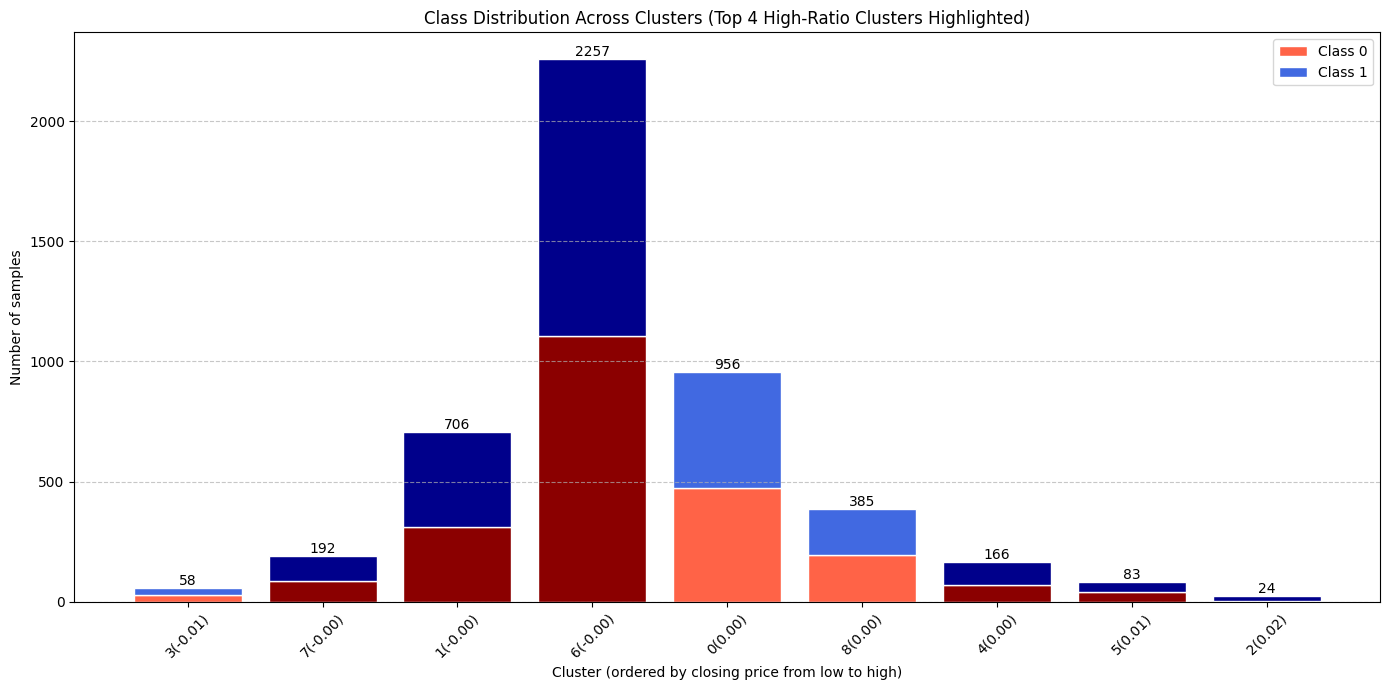

In [14]:
import numpy as np
import matplotlib.pyplot as plt

alternative_n = cluster_models[0].cluster_centers_.shape[0]
# 1. Get cluster centers and sort by closing price
cluster_centers = cluster_models[0].cluster_centers_
closing_prices = cluster_centers[:, -1]
sorted_indices = np.argsort(closing_prices)

# 2. Count class 0 and 1 in each cluster
class0_counts = np.zeros(alternative_n)
class1_counts = np.zeros(alternative_n)

for cluster in range(alternative_n ):
    mask = (train_clusters[:,0]  == cluster)
    #mask = (train_clusters[:,-1] - y_train.min() == cluster)
    #mask = (train_clusters.reshape(-1, 10)[:,-1] == cluster)
    class0_counts[cluster] = np.sum(train_labels[mask] == 0)
    class1_counts[cluster] = np.sum(train_labels[mask] == 1)

# 3. Calculate Class 1 ratio (Class 1 / Total)
total_counts = class0_counts + class1_counts
class1_ratios = np.divide(class1_counts, total_counts, out=np.zeros_like(class1_counts), where=(total_counts != 0))

# 4. Find top 4 clusters with highest Class 1 ratio
top4_ratio_indices = np.argsort(class1_ratios)[::-1][:6]
bottom4_ratio_indices = np.argsort(class1_ratios)[::-1][-3:]
print("Top 4 Clusters with Highest Class 1 Ratio:")
for i, cluster_idx in enumerate(top4_ratio_indices, 1):
    ratio = class1_ratios[cluster_idx]
    print(f"{i}. Cluster {cluster_idx} (Ratio: {ratio:.2f}) - "
          f"Class 0: {int(class0_counts[cluster_idx])}, "
          f"Class 1: {int(class1_counts[cluster_idx])}, "
          f"Closing Price: {closing_prices[cluster_idx]:.2f}")

# 5. Prepare data for plotting (sorted by closing price)
sorted_class0 = class0_counts[sorted_indices]
sorted_class1 = class1_counts[sorted_indices]
sorted_ratios = class1_ratios[sorted_indices]

# 6. Create stacked bar plot (highlight top 4 clusters)
plt.figure(figsize=(14, 7))
bar_width = 0.8
colors_class0 = ['tomato'] * alternative_n
colors_class1 = ['royalblue'] * alternative_n

# Highlight top 4 clusters in the plot (if they appear in sorted order)
for i, cluster_idx in enumerate(sorted_indices):
    if cluster_idx in top4_ratio_indices:
        colors_class0[i] = 'darkred'
        colors_class1[i] = 'darkblue'

# Plot stacked bars
p0 = plt.bar(range(alternative_n), sorted_class0, color=colors_class0,
             edgecolor='white', width=bar_width, label='Class 0')
p1 = plt.bar(range(alternative_n), sorted_class1, bottom=sorted_class0,
             color=colors_class1, edgecolor='white', width=bar_width, label='Class 1')

# 7. Customize the plot
plt.xlabel('Cluster (ordered by closing price from low to high)')
plt.ylabel('Number of samples')
plt.title('Class Distribution Across Clusters (Top 4 High-Ratio Clusters Highlighted)')

# Add cluster index and closing price to x-axis labels
labels = [f'{i}({closing_prices[i]:.2f})' for i in sorted_indices]
plt.xticks(range(alternative_n), labels, rotation=45)

# Add total count labels on bars
for rect0, rect1 in zip(p0, p1):
    height0 = rect0.get_height()
    height1 = rect1.get_height()
    total = height0 + height1
    if total > 0:
        plt.text(rect0.get_x() + rect0.get_width()/2., total + 0.5,
                f'{int(total)}', ha='center', va='bottom')

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [15]:
test_days_spx = extract_normalized_daily_ohlc(test_features1)
test_clusters01 = generate_clusters(test_days_spx, pca_models, cluster_models, feature_steps)
test_clusters_spx = test_clusters01[:, ::-1].copy()

In [16]:
# 3. Evaluation function for cluster analysis
def evaluate_cluster_range(cluster_indices, true_labels, pred_labels):
    """
    Evaluate performance on specific clusters

    Args:
        cluster_indices: List of cluster indices to evaluate
        true_labels: Ground truth labels
        pred_labels: Predicted cluster assignments

    Returns:
        Tuple of (mean accuracy, sample count) or (None, 0) if no samples
    """
    mask = np.isin(pred_labels, cluster_indices)
    y_subset = true_labels[mask]
    return (np.mean(y_subset), len(y_subset)) if len(y_subset) > 0 else (None, 0)

In [17]:
import numpy as np
import torch
from tqdm import tqdm  # For progress bars
from sklearn.metrics import confusion_matrix

# Initialization
batch_size = 30000  # Process data in batches to manage memory usage
all_predicted_tokens = []

# Batch prediction with progress bar
for i in tqdm(range(0, len(test_clusters_spx), batch_size)):
    model.eval()  # Set model to evaluation mode

    # Prepare batch (excluding last token since we're predicting it)
    batch = test_clusters_spx[i:i+batch_size, :-1]
    start_ids = torch.tensor(batch, dtype=torch.long, device=device)

    # Generate predictions - we only need 1 new token prediction
    y = model.generate(start_ids, max_new_tokens=1)
    predicted_tokens = y[:, -1]  # Get the predicted tokens

    all_predicted_tokens.extend(predicted_tokens.cpu().tolist())

predicted_tokens_array = np.array(all_predicted_tokens)

# =============================
# Save predicted tokens as .npy file
# =============================
np.save("predicted_tokens2015-2024csi9+10.npy", predicted_tokens_array)
print(f"Predicted tokens saved to: predicted_tokens2024.npy with shape {predicted_tokens_array.shape}")

100%|██████████| 22/22 [03:45<00:00, 10.27s/it]

Predicted tokens saved to: predicted_tokens2024.npy with shape (633768,)


In [18]:
# Store predictions for evaluation
test_pred1 = predicted_tokens_array

# Evaluate top performing clusters
print("Top Cluster Evaluation:")
for n in range(1, 8):  # Evaluate top 1-7 clusters
    # Get cluster IDs of top n clusters
    clusters = sorted_indices[:n]
    #clusters = [item['cluster'] for item in clusters]

    # Evaluate performance on these clusters
    acc, count = evaluate_cluster_range(clusters, test_labels1, test_pred1)

    if acc is not None:
        # Print accuracy and sample count for these clusters
        print(f"Top {n} clusters: Acc={(1-acc):.4f}, Samples={count}")
    else:
        print(f"Top {n} clusters: No samples")

# Evaluate bottom performing clusters
print("\nBottom Cluster Evaluation:")
for n in range(1, 8):  # Evaluate bottom 1-7 clusters
    # Get cluster IDs of bottom n clusters
    clusters = sorted_indices[-n:]
    #clusters = [item['cluster'] for item in clusters]

    # Evaluate performance on these clusters
    acc, count = evaluate_cluster_range(clusters, test_labels1, test_pred1)

    if acc is not None:
        # Print inverse accuracy (1-acc) since these are worst performers
        print(f"Bottom {n} clusters: Acc={(acc):.4f}, Samples={count}")
    else:
        print(f"Bottom {n} clusters: No samples")

Top Cluster Evaluation:
Top 1 clusters: Acc=0.5237, Samples=38987
Top 2 clusters: Acc=0.5268, Samples=85616
Top 3 clusters: Acc=0.5285, Samples=166061
Top 4 clusters: Acc=0.5363, Samples=416745
Top 5 clusters: Acc=0.5338, Samples=489232
Top 6 clusters: Acc=0.5301, Samples=580417
Top 7 clusters: Acc=0.5285, Samples=602268

Bottom Cluster Evaluation:
Bottom 1 clusters: Acc=0.5521, Samples=12793
Bottom 2 clusters: Acc=0.5402, Samples=31471
Bottom 3 clusters: Acc=0.5290, Samples=53322
Bottom 4 clusters: Acc=0.5044, Samples=144507
Bottom 5 clusters: Acc=0.4963, Samples=216994
Bottom 6 clusters: Acc=0.4761, Samples=467678
Bottom 7 clusters: Acc=0.4751, Samples=548123
